# **Nuevo enfoque de optimización metaheurística**

### Librerías

In [1]:
from concurrent.futures import ThreadPoolExecutor
from scipy.sparse import coo_matrix, csc_matrix
from numpy.random import choice, randint, rand
from matplotlib.pyplot import subplots, style
from scipy.sparse.linalg import spsolve
from numpy import (
    sum, array, concatenate, linspace, 
    power, ones, zeros, log10, matmul, 
    arange, zeros_like, meshgrid 
)
from numpy.linalg import norm, solve
from itertools import repeat
from time import time

## Método

### Funciones necesarias para el método de optimización

#### Generación de matrices definidas positivas

In [2]:
def generate_matrix(n, delta):
    data = rand(n*(n+1)//2 - ((n-(delta-1))*(n-delta)//2))
    I = concatenate([ones(delta)*i for i in range(n-(delta-1))]).astype(int)
    I1 = concatenate([ones(n-i)*i for i in range(n-delta+1, n)]).astype(int)
    J = concatenate([range(i, i+delta) for i in range(n-(delta-1))]).astype(int)
    J1 = concatenate([range(i, n) for i in range(n-delta+1, n)]).astype(int)
    A = coo_matrix((data, (concatenate([I, I1]), concatenate([J, J1]))))
    return A.toarray()

#### Generación de direcciones aleatorias

In [3]:
def directions_set(n, pk, delta):
    B_i = generate_matrix(n, delta)
    phi_k_i = matmul(B_i, pk)
    return phi_k_i

#### Algoritmo genético

In [4]:
space = linspace(-1.0, 1.0, 10**4)
def generate_neighborhood(alpha):
    pos_alpha = randint(alpha.shape[0])
    new_space = choice(space, 1)[0]
    alpha[pos_alpha] = new_space
    return alpha, pos_alpha

def objetive(function, xk, Psi_k, alpha):
    g = norm(-function.gradient(xk + matmul(Psi_k, alpha)))
    return g

In [5]:
def geneticAlgorithm(xk, Psi_k, alpha, function, neighborhood_amount=20, max_iteraciones=100):
    actual, best_solution = alpha.copy(), alpha.copy()
    actual_value, best_solution_value = objetive(function, xk, Psi_k, actual), objetive(function, xk, Psi_k, best_solution)

    for _ in range(max_iteraciones):
        neighborhoods = [*map(generate_neighborhood, [actual.copy() for __ in range(neighborhood_amount)])]

        best_neighborhood, best_neighborhood_value = None, float('inf')
        for neighborhood, position in neighborhoods:
            value = objetive(function, xk, Psi_k, neighborhood)
            if value < best_solution_value:
                best_solution, best_solution_value = neighborhood.copy(), value

            if value < best_neighborhood_value:
                best_neighborhood, best_neighborhood_value = neighborhood.copy(), value

        if best_neighborhood_value < actual_value:
            actual, actual_value = best_neighborhood.copy(), best_neighborhood_value

        if actual_value < best_solution_value:
            best_solution, best_solution_value = actual.copy(), actual_value
    return best_solution

### Método de optimización

In [6]:
def main(function, method, n, I, inicial_xk):   
    # Variables iniciales
    delta = I//5
    xk, alpha = inicial_xk.copy(), ones(I)
    Gk, M = [norm(-function.gradient(xk))], 100

    for m in range(M):
        # Calculo del del gradiente, hessiana
        gf = -function.gradient(xk)
        Hf = function.hessian(xk)
        # Calculo dirección de Newton
        pk = spsolve(csc_matrix(Hf), gf)
        # Construcción conjunto de direcciones
        with ThreadPoolExecutor(max_workers=I) as executor:
            Phi_k = array([*executor.map(
                    directions_set,
                    repeat(n),
                    repeat(pk),
                    repeat(delta, I)
            )]).T
        # Restricción del espacio al cono
        Phi_k = Phi_k/norm(Phi_k)
        # Minimización de alpha
        alpha = method(xk, Phi_k, alpha, function)
        xk += matmul(Phi_k, alpha)
        # Gráfico del gradiente
        gf = -function.gradient(xk)
        Gk.append(norm(gf))
    return Gk, xk

## Pruebas

### Métodos de comparación y prueba

In [7]:
def classic_newton_method(function, inicial_xk):
    xk = inicial_xk.copy()
    M = 100
    Gk = []

    for _ in range(M):
        gk = -function.gradient(xk)
        Hk = function.hessian(xk)
        sk = spsolve(csc_matrix(Hk), gk)
        xk += sk
        gk = -function.gradient(xk)
        Gk.append(norm(gk))
    return Gk, xk

In [8]:
def optimize_alpha2(xk, Psi_k, Alpha, function):
    grad_f = lambda alpha: Psi_k.T @ function.gradient(xk + Psi_k @ alpha)
    hess_f = lambda alpha: Psi_k.T @ function.hessian(xk + Psi_k @ alpha) @ Psi_k

    alpha_star = Alpha.copy()
    max_iter = 100
    for i in range(max_iter):
        grad = -grad_f(alpha_star)
        hess = hess_f(alpha_star)
        delta_alpha = solve(hess, grad)
        alpha_star += delta_alpha
    return alpha_star

### Funciones de prueba en forma de valle

#### Función Dixon-Price

\begin{equation*}
  f(x) = (x_1 - 1)^{2} + \sum_{i = 2}^{n}{\left[i(2x_{i}^{2} - x_{i - 1})^{2}\right]}
\end{equation*}

In [9]:
class dixon_price:
    # Función 
    def fun(x):
        x = x[0,:]
        n = x.shape[0]
        f = (x[0] - 1)**2 + sum([(i + 1)*((2*(x[i]**2) - x[i-1])**2) for i in range(1, n)])
        return f

    # Vector gradiente
    def gradient(x):
        x = x[0,:]
        n = x.shape[0]
        if n == 1:
          return 2*x[0] - 2
        g = arange(8, 8*n + 1, 8)*x
        g[1:] = g[1:]*(-x[:-1] + 2*x[1:]**2)
        g[1:-1] = g[1:-1] + arange(6, 2*n + 1, 2)*x[1:-1] - arange(12, 4*n + 1, 4)*(x[2:]**2)
        g[0] = 6*x[0] - 8*x[1]**2 - 2
        return g

    # Matriz hessiana
    def hessian(x):
        x = x[0,:]
        n = x.shape[0]
        if n == 1:
          return coo_matrix(([2], ([0], [0])));
        dp = [6]
        dp.extend([-(16 + 8*i)*x[i] + (96 + 48*i)*(x[i+1]**2) for i in range(0, n-1)])
        d1 = array(dp)
        d1[1:-1] += arange(6, 2*n + 1, 2)
        d2 = -arange(16, 8*n + 1, 8)*x[1:]
        ind = arange(0, n, 1)
        V = concatenate((d1, d2, d2))
        I = concatenate((ind, ind[:-1], ind[:-1] + 1))
        J = concatenate((ind, ind[:-1] + 1, ind[:-1]))
        H = coo_matrix((V, (I, J)))
        return H

    # Error de la solución y los mínimos de la función
    def error(xk):
        x = xk[0,:]
        n = x.shape[0]
        true_xk = [2**(-(2**i - 2)/(2**i)) for i in range(1, n+1)]
        return norm(x - true_xk)

#### Función Rosenbrock

\begin{equation*}
  f(x) = \sum_{i = 1}^{n - 1}{100 (x_{i+1} - x_{i}^{2})^{2} + (x_i - 1)^{2}}
\end{equation*}

In [10]:
class rosenbrock:
    # Función
    def fun(x):
        x = x[0,:]
        n = x.shape[0]
        f = sum([100*(x[i+1]-x[i]**2)**2 + (1-x[i])**2 for i in range(n-1)])
        return f

    # Vector gradiente
    def gradient(x):
        x = x[0,:]
        n = x.shape[0]
        g = zeros_like(x)
        g[:-1] -= 2
        g[1:] -= 200*x[:-1]**2
        g[:-1] -= 400 * x[:-1] * (-x[:-1]**2 + x[1:])
        g[1:-1] += 202 * x[1:-1]
        g[0] += 2*x[0]
        g[-1] += 200*x[-1]
        return g

    # Matriz hessiana
    def hessian(x):
        x = x[0,:]
        n = x.shape[0]
        H = zeros((n,n))
        dp = zeros_like(x)
        ds = -400*x[:-1]
        dp[:-1] = 1200 * x[:-1]**2 - 400*x[1:]
        dp[1:-1] += 202
        dp[0]+=2
        dp[-1] += 200
        data = concatenate((dp,ds,ds))
        ind = arange(0, n)
        I = concatenate((ind, ind[:-1], ind[1:]))
        J = concatenate((ind, ind[1:], ind[:-1]))
        H = coo_matrix((data,(I,J)))
        return H.toarray()

    # Error de la solución y los mínimos de la función
    def error(xk):
        x = xk[0,:]
        n = x.shape[0]
        true_xk = ones(n)
        true_xk[:-1] *= 1.0
        return norm(x - true_xk)

### Ejecución y pruebas

#### Prueba con la función Dixon-Price

##### Prueba con un valor inicial conocido

Nuevo enfoque: error = 0.007432138920957251 min gradient = 24.947105789123793 time = 57.44321346282959
Método clásico de Newton: error = 4.577566798522237e-16 min gradient = 9.546575322081919e-14 time = 0.2559983730316162
Otro método de optimización alpha: error = 0.03226772043868942 min gradient = 177.28849472365118 time = 43.63913369178772




C:\Users\dysac\AppData\Local\Temp\ipykernel_9124\930836787.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


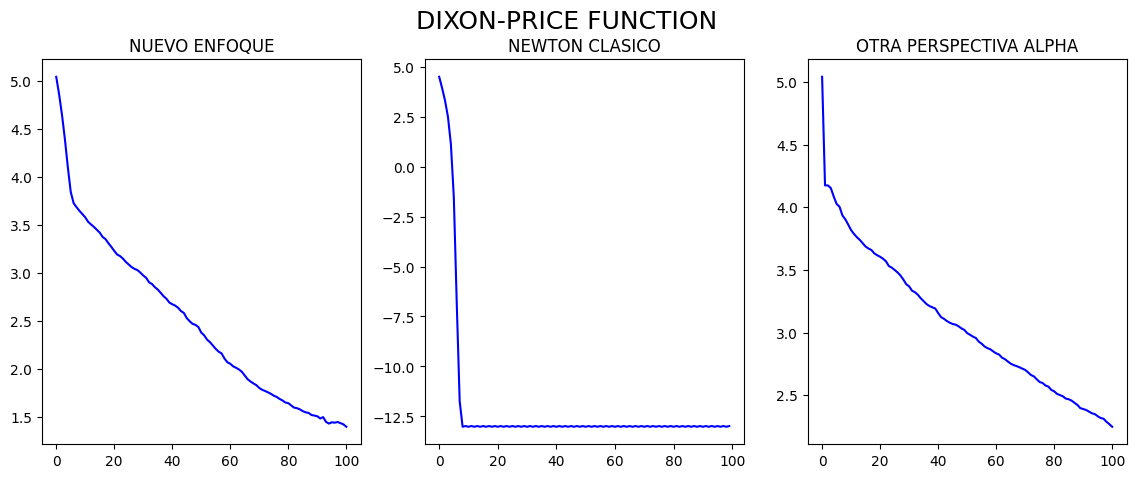

In [11]:
n, I = 10**3, 10**1
initial_xk = ones((1, n))

fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(14, 5))
fig.suptitle('DIXON-PRICE FUNCTION', fontsize=18)

start = time()
Gk1, xk1 = main(dixon_price, geneticAlgorithm, n, I, initial_xk)
end = time()
print('Nuevo enfoque:', 'error =', dixon_price.error(xk1), 'min gradient =', min(Gk1), 'time =', end - start)
ax1.set_title('NUEVO ENFOQUE')
ax1.plot(log10(array(Gk1)), '-b')

start = time()
Gk2, xk2 = classic_newton_method(dixon_price, initial_xk)
end = time()
print('Método clásico de Newton:', 'error =', dixon_price.error(xk2), 'min gradient =', min(Gk2), 'time =', end - start)
ax2.set_title('NEWTON CLASICO')
ax2.plot(log10(array(Gk2)), '-b')

start = time()
Gk3, xk3 = main(dixon_price, optimize_alpha2, n, I, initial_xk)
end = time()
print('Otro método de optimización alpha:', 'error =', dixon_price.error(xk3), 'min gradient =', min(Gk3), 'time =', end - start)
ax3.set_title('OTRA PERSPECTIVA ALPHA')
ax3.plot(log10(array(Gk3)), '-b')

print('\n')
fig.show()

##### Prueba con valor inicial aleatorio

Nuevo enfoque: error = 12.5136509276196 min gradient = 9540.963346059589 time = 60.78064441680908


C:\Users\dysac\AppData\Local\Temp\ipykernel_9124\500721174.py:16: RuntimeWarning: overflow encountered in multiply
  g[1:] = g[1:]*(-x[:-1] + 2*x[1:]**2)


Método clásico de Newton: error = nan min gradient = 435889381.1446166 time = 0.2599985599517822
Otro método de optimización alpha: error = 13.527334012082436 min gradient = 6871.746930573827 time = 39.96051788330078




C:\Users\dysac\AppData\Local\Temp\ipykernel_9124\349692611.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


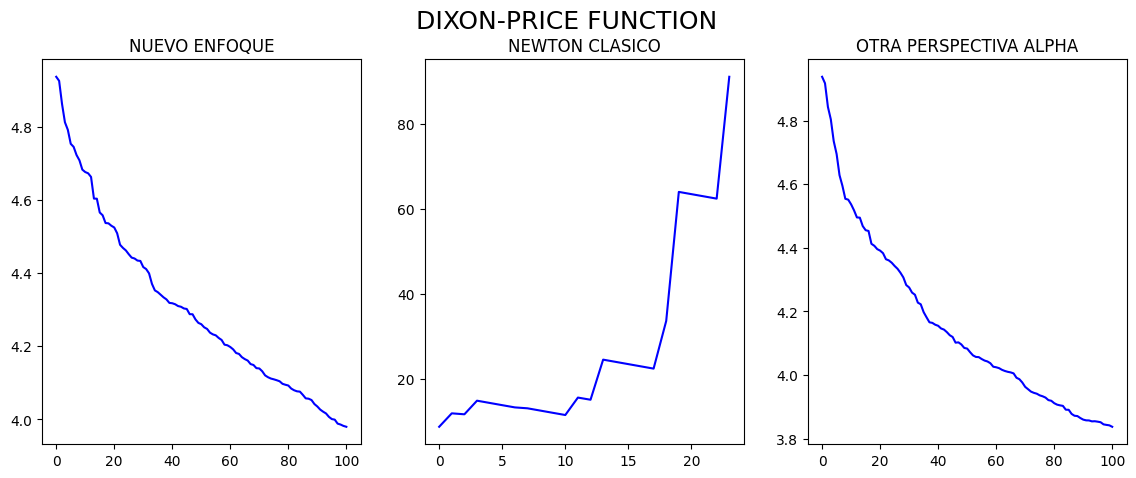

In [16]:
n, I = 10**3, 10**1
initial_xk = rand(n).reshape(1, -1)

fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(14, 5))
fig.suptitle('DIXON-PRICE FUNCTION', fontsize=18)

start = time()
Gk1, xk1 = main(dixon_price, geneticAlgorithm, n, I, initial_xk)
end = time()
print('Nuevo enfoque:', 'error =', dixon_price.error(xk1), 'min gradient =', min(Gk1), 'time =', end - start)
ax1.set_title('NUEVO ENFOQUE')
ax1.plot(log10(array(Gk1)), '-b')

start = time()
Gk2, xk2 = classic_newton_method(dixon_price, initial_xk)
end = time()
print('Método clásico de Newton:', 'error =', dixon_price.error(xk2), 'min gradient =', min(Gk2), 'time =', end - start)
ax2.set_title('NEWTON CLASICO')
ax2.plot(log10(array(Gk2)), '-b')

start = time()
Gk3, xk3 = main(dixon_price, optimize_alpha2, n, I, initial_xk)
end = time()
print('Otro método de optimización alpha:', 'error =', dixon_price.error(xk3), 'min gradient =', min(Gk3), 'time =', end - start)
ax3.set_title('OTRA PERSPECTIVA ALPHA')
ax3.plot(log10(array(Gk3)), '-b')

print('\n')
fig.show()

#### Prueba con la función Rosenbrock

##### Prueba con valor inicial conocido

Nuevo enfoque: error = 15.851677577843 min gradient = 65.52144561623504 time = 67.82553958892822
Método clásico de Newton: error = 6754.390249105943 min gradient = 1875.4142610595538 time = 1.899000644683838
Otro método de optimización alpha: error = 15.932706363584701 min gradient = 78.09609465267773 time = 84.74858808517456




C:\Users\dysac\AppData\Local\Temp\ipykernel_9124\2878062542.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


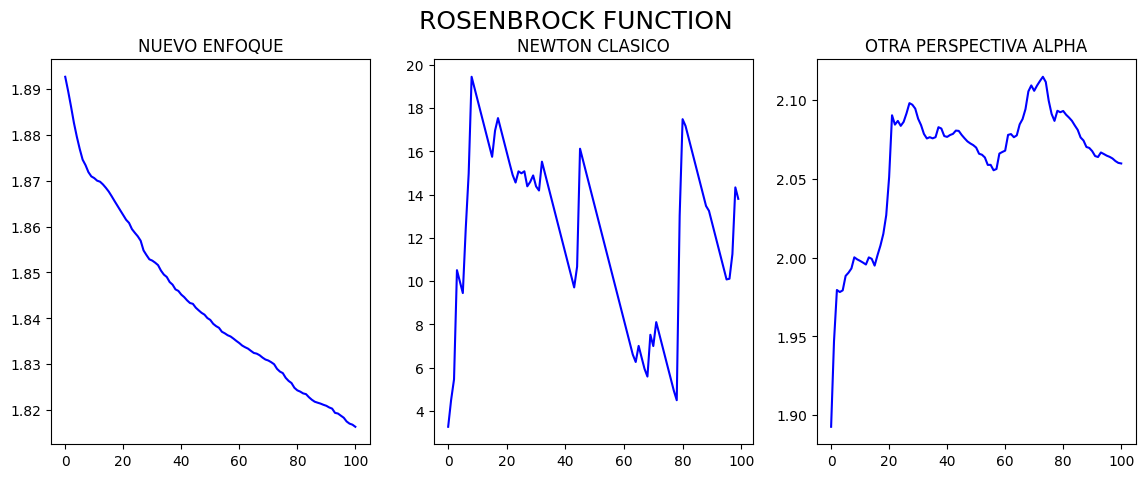

In [21]:
n, I = 10**3, 10**1
initial_xk = ones((1, n))*0.5

fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(14, 5))
fig.suptitle('ROSENBROCK FUNCTION', fontsize=18)

start = time()
Gk1, xk1 = main(rosenbrock, geneticAlgorithm, n, I, initial_xk)
end = time()
print('Nuevo enfoque:', 'error =', rosenbrock.error(xk1), 'min gradient =', min(Gk1), 'time =', end - start)
ax1.set_title('NUEVO ENFOQUE')
ax1.plot(log10(array(Gk1)), '-b')

start = time()
Gk2, xk2 = classic_newton_method(rosenbrock, initial_xk)
end = time()
print('Método clásico de Newton:', 'error =', rosenbrock.error(xk2), 'min gradient =', min(Gk2), 'time =', end - start)
ax2.set_title('NEWTON CLASICO')
ax2.plot(log10(array(Gk2)), '-b')

start = time()
Gk3, xk3 = main(rosenbrock, optimize_alpha2, n, I, initial_xk)
end = time()
print('Otro método de optimización alpha:', 'error =', rosenbrock.error(xk3), 'min gradient =', min(Gk3), 'time =', end - start)
ax3.set_title('OTRA PERSPECTIVA ALPHA')
ax3.plot(log10(array(Gk3)), '-b')

print('\n')
fig.show()

##### Prueba con valor inicial aleatorio

Nuevo enfoque: error = 24.074973288876937 min gradient = 1814.0674005167216 time = 54.944111824035645
Método clásico de Newton: error = 101.23896076752574 min gradient = 66487.20522049589 time = 1.967998743057251
Otro método de optimización alpha: error = 25.772938866463036 min gradient = 1151.9828668181835 time = 98.61693906784058




C:\Users\dysac\AppData\Local\Temp\ipykernel_9124\2665063750.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


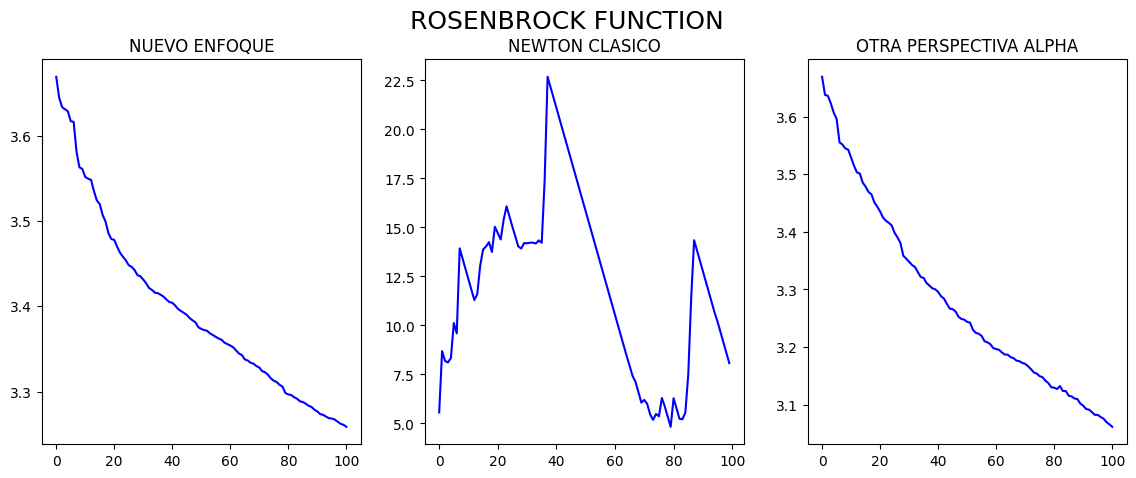

In [20]:
n, I = 10**3, 10**1
initial_xk = rand(n).reshape(1, -1)

fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(14, 5))
fig.suptitle('ROSENBROCK FUNCTION', fontsize=18)

start = time()
Gk1, xk1 = main(rosenbrock, geneticAlgorithm, n, I, initial_xk)
end = time()
print('Nuevo enfoque:', 'error =', rosenbrock.error(xk1), 'min gradient =', min(Gk1), 'time =', end - start)
ax1.set_title('NUEVO ENFOQUE')
ax1.plot(log10(array(Gk1)), '-b')

start = time()
Gk2, xk2 = classic_newton_method(rosenbrock, initial_xk)
end = time()
print('Método clásico de Newton:', 'error =', rosenbrock.error(xk2), 'min gradient =', min(Gk2), 'time =', end - start)
ax2.set_title('NEWTON CLASICO')
ax2.plot(log10(array(Gk2)), '-b')

start = time()
Gk3, xk3 = main(rosenbrock, optimize_alpha2, n, I, initial_xk)
end = time()
print('Otro método de optimización alpha:', 'error =', rosenbrock.error(xk3), 'min gradient =', min(Gk3), 'time =', end - start)
ax3.set_title('OTRA PERSPECTIVA ALPHA')
ax3.plot(log10(array(Gk3)), '-b')

print('\n')
fig.show()